
# Feature Engineering - TMDB Movie Popularity (2010-2025)

This notebook builds a leakage-safe, model-ready feature table for **pre-release popularity prediction**.

Decision framing:
- Goal: improve pre-release popularity forecasts.
- Primary metric downstream: RMSE on raw popularity.
- Guardrail: features must be available before release.


In [1]:

import ast
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
np.random.seed(42)



## Project-Rubric Alignment

- **Use case:** Predict movie popularity using only pre-release information.
- **Scope (3-week POV):** focus on interpretable, reproducible tabular features (no heavy NLP).
- **Best-practice controls:** strict leakage prevention, explicit missingness handling, and feature diagnostics.
- **Deliverable from this notebook:** a clean feature matrix ready for model benchmarking.


## 1) Load raw data

In [2]:

RAW_PATH = "../data/movies_2010_2025.csv"
df = pd.read_csv(RAW_PATH)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

print("Raw shape:", df.shape)
print("Columns:", len(df.columns))
df.head(2)


Raw shape: (9290, 51)
Columns: 51


,movie_id,title,release_date,runtime,original_language,popularity,vote_average,vote_count,budget,revenue,...,actor4_popularity,actor4_department,actor5_id,actor5_name,actor5_character,actor5_gender,actor5_popularity,actor5_department,cast_pop_mean,cast_pop_max
0,27205,Inception,2010-07-15,148,en,32.8952,8.37,38655,160000000,839030630,...,9.6156,Acting,27578.0,Elliot Page,Ariadne,3.0,4.8289,Acting,7.38976,12.2774
1,38757,Tangled,2010-11-24,100,en,19.8760,7.61,12179,260000000,592461732,...,4.9563,Acting,22132.0,M.C. Gainey,Captain of the Guard (voice),2.0,2.1777,Acting,2.62706,4.9563


## 2) Helpers + leakage policy

In [3]:

def safe_parse_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        x = x.strip()
        if x in ("", "[]"):
            return []
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except (ValueError, SyntaxError):
            return []
    return []

# Target
if "popularity" not in df.columns:
    raise ValueError("Expected target column 'popularity' in raw file")

target = df["popularity"].copy()

# Strict pre-release leakage exclusions
leakage_cols = ["popularity", "vote_average", "vote_count", "revenue"]
id_cols = ["movie_id", "title"]
text_identity_cols = [
    "status", "director_id", "director_name", "director_department",
    "actor1_id", "actor1_name", "actor1_character", "actor1_department",
    "actor2_id", "actor2_name", "actor2_character", "actor2_department",
    "actor3_id", "actor3_name", "actor3_character", "actor3_department",
    "actor4_id", "actor4_name", "actor4_character", "actor4_department",
    "actor5_id", "actor5_name", "actor5_character", "actor5_department",
]

exclude_cols = leakage_cols + id_cols + text_identity_cols
print("Target rows:", target.shape[0])
print("Excluded column count:", len(exclude_cols))


Target rows: 9290
Excluded column count: 30


## 3) Parse list-like columns

In [4]:

for col in ["genres", "keywords"]:
    if col in df.columns:
        df[col] = df[col].apply(safe_parse_list)

print("Parsed genres sample:", df["genres"].iloc[0][:5])
print("Parsed keywords sample:", df["keywords"].iloc[0][:5])


Parsed genres sample: ['Action', 'Science Fiction', 'Adventure']
Parsed keywords sample: ['rescue', 'mission', 'dreams', 'airplane', 'paris, france']


## 4) Temporal features

In [5]:

df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year
df["release_month"] = df["release_date"].dt.month
df["release_quarter"] = df["release_date"].dt.quarter

df["release_month_sin"] = np.sin(2 * np.pi * df["release_month"].fillna(1) / 12)
df["release_month_cos"] = np.cos(2 * np.pi * df["release_month"].fillna(1) / 12)

df["is_summer_release"] = df["release_month"].isin([5, 6, 7]).astype(int)
df["is_holiday_release"] = df["release_month"].isin([11, 12]).astype(int)

df["release_is_missing"] = df["release_date"].isna().astype(int)

for col in ["release_year", "release_month", "release_quarter"]:
    med = df[col].median()
    df[col] = df[col].fillna(med)

print(df[["release_year", "release_month", "release_quarter", "release_is_missing"]].describe())


       release_year  release_month  release_quarter  release_is_missing
count   9290.000000    9290.000000      9290.000000         9290.000000
mean    2017.456512       6.752530         2.587406            0.000108
std        4.623364       3.463668         1.136100            0.010375
min     2010.000000       1.000000         1.000000            0.000000
25%     2013.000000       4.000000         2.000000            0.000000
50%     2017.000000       7.000000         3.000000            0.000000
75%     2021.000000      10.000000         4.000000            0.000000
max     2025.000000      12.000000         4.000000            1.000000


## 5) Talent features

In [6]:

actor_pop_cols = [f"actor{i}_popularity" for i in range(1, 6)]
actor_gender_cols = [f"actor{i}_gender" for i in range(1, 6)]

for col in actor_pop_cols + ["director_popularity", "cast_pop_mean", "cast_pop_max"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

all_actor_pops = df[actor_pop_cols].to_numpy(dtype=float).reshape(-1)
all_actor_pops = all_actor_pops[np.isfinite(all_actor_pops) & (all_actor_pops > 0)]
star_threshold = np.percentile(all_actor_pops, 75) if len(all_actor_pops) else 0.0

df["star_count"] = (df[actor_pop_cols].fillna(0) > star_threshold).sum(axis=1)
df["cast_popularity_std"] = df[actor_pop_cols].fillna(0).std(axis=1)
df["cast_popularity_range"] = (
    df[actor_pop_cols].fillna(0).max(axis=1) - df[actor_pop_cols].fillna(0).min(axis=1)
)
df["top2_cast_pop_sum"] = np.sort(df[actor_pop_cols].fillna(0).to_numpy(), axis=1)[:, -2:].sum(axis=1)

def female_ratio(row):
    known = [g for g in row if g in (1.0, 2.0)]
    if not known:
        return 0.5
    return sum(1 for g in known if g == 1.0) / len(known)

df["cast_gender_ratio"] = df[actor_gender_cols].apply(female_ratio, axis=1)
df["director_is_female"] = (df["director_gender"] == 1.0).astype(int)

df["director_pop_missing"] = df["director_popularity"].isna().astype(int)

print("Star threshold:", round(float(star_threshold), 4))
df[["star_count", "cast_popularity_std", "top2_cast_pop_sum", "cast_gender_ratio"]].describe()


Star threshold: 2.9868


,star_count,cast_popularity_std,top2_cast_pop_sum,cast_gender_ratio
count,9290.000000,9290.000000,9290.000000,9290.000000
mean,1.147578,1.426811,6.386194,0.412983
std,1.364494,1.955505,6.454998,0.259384
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.681943,2.859475,0.200000
50%,1.000000,1.156562,5.031150,0.400000
75%,2.000000,1.701521,8.328800,0.600000
max,5.000000,94.101750,250.873000,1.000000


## 6) Content + language + text-light features

In [7]:

# Genres multi-hot
all_genres = sorted({g for row in df["genres"] for g in row})
for g in all_genres:
    df[f"genre_{g}"] = df["genres"].apply(lambda x, gg=g: int(gg in x))

df["num_genres"] = df["genres"].apply(len)

# Keywords aggregate signals
df["keyword_count"] = df["keywords"].apply(len)
df["keyword_unique_ratio"] = df["keywords"].apply(lambda x: (len(set(x)) / len(x)) if len(x) else 0.0)

# Add top keyword indicators (controls dimensionality)
flat_kw = [kw for row in df["keywords"] for kw in row]
kw_counts = pd.Series(flat_kw).value_counts() if flat_kw else pd.Series(dtype=int)
top_keywords = kw_counts.head(25).index.tolist()
for kw in top_keywords:
    safe_kw = str(kw).strip().lower().replace(" ", "_").replace("-", "_")
    safe_kw = "".join(ch for ch in safe_kw if ch.isalnum() or ch == "_")
    if not safe_kw:
        continue
    df[f"kw_{safe_kw}"] = df["keywords"].apply(lambda x, kk=kw: int(kk in x))

# Language one-hot (top-K)
top_lang = df["original_language"].fillna("unknown").value_counts().head(8).index.tolist()
for lang in top_lang:
    df[f"lang_{lang}"] = (df["original_language"].fillna("unknown") == lang).astype(int)
df["lang_other"] = (~df["original_language"].fillna("unknown").isin(top_lang)).astype(int)
df["is_english"] = (df["original_language"] == "en").astype(int)

# Overview-derived non-NLP signals (safe pre-release)
overview = df["overview"].fillna("").astype(str)
df["has_overview"] = overview.ne("").astype(int)
df["overview_char_count"] = overview.str.len()
df["overview_word_count"] = overview.str.split().map(len)
df["overview_unique_word_ratio"] = overview.apply(
    lambda t: (len(set(t.lower().split())) / max(len(t.split()), 1)) if t else 0.0
)

print("Genres:", len(all_genres), "Top keyword dummies:", len([c for c in df.columns if c.startswith('kw_')]))


Genres: 19 Top keyword dummies: 25


## 7) Production and robustness features

In [8]:

for c in ["budget", "runtime", "director_popularity", "cast_pop_mean", "cast_pop_max"] + actor_pop_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["has_budget"] = (df["budget"].fillna(0) > 0).astype(int)
df["log_budget"] = np.log1p(df["budget"].clip(lower=0).fillna(0))

df["runtime_missing"] = df["runtime"].isna().astype(int)
df["runtime"] = df["runtime"].fillna(df["runtime"].median())
df["log_runtime"] = np.log1p(df["runtime"].clip(lower=0))

df["director_popularity"] = df["director_popularity"].fillna(df["director_popularity"].median())
df["cast_pop_mean"] = df["cast_pop_mean"].fillna(df["cast_pop_mean"].median())
df["cast_pop_max"] = df["cast_pop_max"].fillna(df["cast_pop_max"].median())

for c in actor_pop_cols:
    df[c] = df[c].fillna(0)

print(df[["log_budget", "runtime", "log_runtime", "has_budget"]].describe())


        log_budget      runtime  log_runtime   has_budget
count  9290.000000  9290.000000  9290.000000  9290.000000
mean      4.709160    81.390635     4.032224     0.297417
std       7.423386    44.067500     1.224041     0.457146
min       0.000000     0.000000     0.000000     0.000000
25%       0.000000    67.000000     4.219508     0.000000
50%       0.000000    92.000000     4.532599     0.000000
75%      13.815512   107.000000     4.682131     1.000000
max      20.009712   950.000000     6.857514     1.000000


## 8) Assemble numeric feature matrix + QC checks

In [9]:

# Drop leakage/raw identity columns and intermediates
extra_drop = [
    "release_date", "genres", "keywords", "budget", "overview", "original_language",
    "director_gender",
    "actor1_gender", "actor2_gender", "actor3_gender", "actor4_gender", "actor5_gender",
]

drop_cols = [c for c in (exclude_cols + extra_drop) if c in df.columns]
features = df.drop(columns=drop_cols).copy()

# Keep only numeric columns
numeric_cols = features.select_dtypes(include=[np.number]).columns.tolist()
features = features[numeric_cols].copy()

# Final imputation pass for safety
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(features.median(numeric_only=True))

# Leakage checks
for c in leakage_cols:
    assert c not in features.columns, f"Leakage column present: {c}"
assert features.isna().sum().sum() == 0, "Features contain missing values"

print("Engineered feature shape:", features.shape)
print("Numeric columns:", len(features.columns))
features.head(2)


Engineered feature shape: (9290, 89)
Numeric columns: 89


,runtime,director_popularity,actor1_popularity,actor2_popularity,actor3_popularity,actor4_popularity,actor5_popularity,cast_pop_mean,cast_pop_max,release_year,...,lang_other,is_english,has_overview,overview_char_count,overview_word_count,overview_unique_word_ratio,has_budget,log_budget,runtime_missing,log_runtime
0,148,8.2813,12.2774,5.6445,4.5824,9.6156,4.8289,7.38976,12.2774,2010.0,...,0,1,1,280,44,0.840909,1,18.890684,0,5.003946
1,100,5.1258,2.1981,1.9780,1.8252,4.9563,2.1777,2.62706,4.9563,2010.0,...,0,1,1,286,50,0.860000,1,19.376192,0,4.615121


## 9) Quick feature diagnostics

                            mean        std     min        max
runtime                81.390635  44.067500     0.0   950.0000
director_popularity     1.209358   1.361564     0.0    20.8778
actor1_popularity       2.674343   3.484476     0.0    88.1540
actor2_popularity       2.167565   3.548816     0.0   224.1500
actor3_popularity       1.829108   2.400900     0.0    85.4980
actor4_popularity       1.603090   2.389784     0.0   145.2190
actor5_popularity       1.417261   1.819295     0.0    24.6940
cast_pop_mean           2.023336   1.876921     0.0    56.7840
cast_pop_max            4.085244   4.903623     0.0   224.1500
release_year         2017.456512   4.623364  2010.0  2025.0000
release_month           6.752530   3.463668     1.0    12.0000
release_quarter         2.587406   1.136100     1.0     4.0000
release_month_sin      -0.076374   0.720179    -1.0     1.0000
release_month_cos       0.046792   0.688060    -1.0     1.0000
is_summer_release       0.218837   0.413480     0.0    

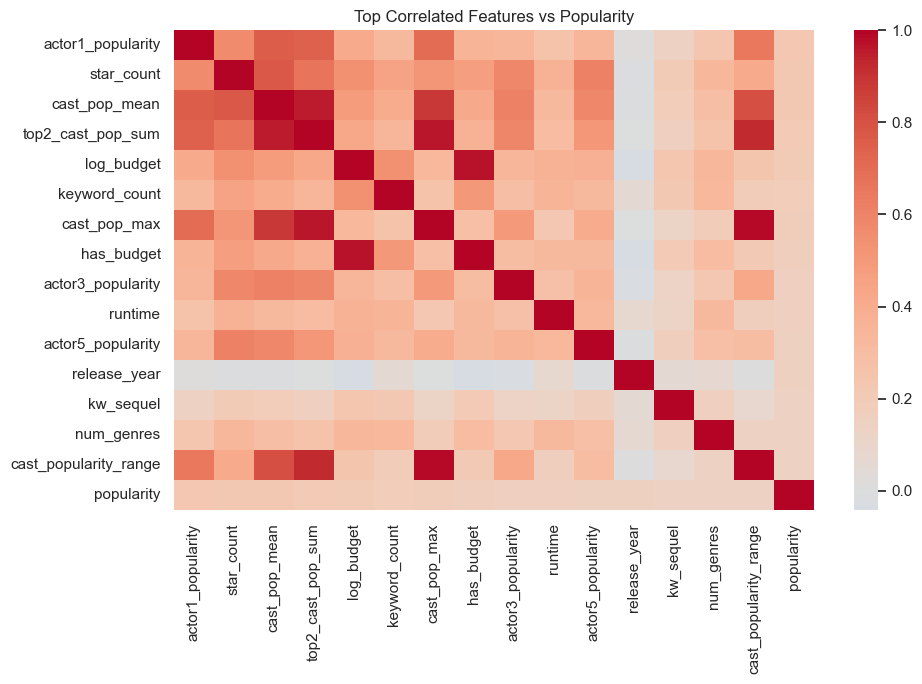

actor1_popularity        0.230680
star_count               0.225317
cast_pop_mean            0.225183
top2_cast_pop_sum        0.205975
log_budget               0.201335
keyword_count            0.188566
cast_pop_max             0.176059
has_budget               0.171584
actor3_popularity        0.159383
runtime                  0.158081
actor5_popularity        0.151466
release_year             0.150849
kw_sequel                0.148396
num_genres               0.147089
cast_popularity_range    0.144904
cast_popularity_std      0.137263
director_popularity      0.132822
genre_Action             0.130919
genre_Adventure          0.130840
actor4_popularity        0.125638
Name: popularity, dtype: float64

In [10]:

print(features.describe().T[["mean", "std", "min", "max"]].head(15))

# Correlation with target (top abs)
corr = features.assign(popularity=target.values).corr(numeric_only=True)["popularity"].drop("popularity")
top_corr = corr.abs().sort_values(ascending=False).head(15).index.tolist()

plt.figure(figsize=(10, 7))
heat = features[top_corr].assign(popularity=target.values).corr(numeric_only=True)
sns.heatmap(heat, cmap="coolwarm", center=0)
plt.title("Top Correlated Features vs Popularity")
plt.tight_layout()
plt.show()

corr.sort_values(key=lambda s: s.abs(), ascending=False).head(20)


## 10) Export modeling datasets

In [11]:

out_features = "../data/data_cleaned_engineered.csv"
out_model = "../data/data_model_with_target.csv"

features.to_csv(out_features, index=False)
model_df = features.copy()
model_df["popularity"] = target.values
model_df.to_csv(out_model, index=False)

print("Saved:", out_features, features.shape)
print("Saved:", out_model, model_df.shape)


Saved: ../data/data_cleaned_engineered.csv (9290, 89)
Saved: ../data/data_model_with_target.csv (9290, 90)
